# Mod 4 Project - Starter Notebook (EDIT THIS)

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [244]:
#importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

from sklearn.metrics import r2_score, mean_squared_error


In [2]:
#importing Zillow housing dataset
df = pd.read_csv('zillow_data.csv')


## Choosing a state from the dataset - Utah

For this project I will expolore Utah as my chosen state. Utah is the state with the lowest median age (30.9 years) of all the US states. This is due to a large population growth in the last ten years. Between 2010 and 2018 the population in Utah grew by 14%. This means that there are many young people in Utah who will be looking for their first home to purchase. 

I will not filter this state and chosen counties from the original dataset

In [3]:
#filtering Utah zipcodes from dataset
utah  = df.loc[df.State == 'UT']

#121 unique zipcodes in Utah
len(utah.RegionName) 

121

In [4]:
#21 counties in Utah
len(utah.CountyName.unique()) 

21

In [5]:
utah.CountyName.unique()
# high pop counties = Salt Lake, Utah, Davis, Weber, Washington, Cashe, Tooele, Box Elder, Iron, Summit

array(['Weber', 'Davis', 'Utah', 'Salt Lake', 'Washington', 'Tooele',
       'Cache', 'Uintah', 'Box Elder', 'Summit', 'Iron', 'Wasatch',
       'Carbon', 'Duchesne', 'Morgan', 'Sevier', 'Kane', 'Juab',
       'Sanpete', 'San Juan', 'Garfield'], dtype=object)

Although there are 21 Utah counties in the dataset, over 90% of Utah's population lives in the following 10 counties:
* Salt Lake
* Utah
* Davis
* Weber
* Washington
* Cashe
* Tooele
* Box Elder
* Iron
* Summit

I will not filter these counties from the dataframe

In [6]:
#filtering for top 10 most populated counties. 90% of Utah population lives in these counties
utah = utah.loc[(utah['CountyName']== 'Salt Lake') |(utah['CountyName']== 'Utah')|(utah['CountyName']== 'Davis')|(utah['CountyName']== 'Weber')|(utah['CountyName']== 'Washington')|(utah['CountyName']== 'Cache')|(utah['CountyName']== 'Tooele')|(utah['CountyName']== 'Box Elder')|(utah['CountyName']== 'Iron')|(utah['CountyName']== 'Summit')]

In [7]:
#my dataset now has 102 zipcodes
len(utah.RegionName)

102

# Step 2: Data Preprocessing

## Transforming dataframe

In this step I will format my dataframe from wide format to long format, set the date columns as index. This will allow me to create time series.

In [8]:
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','City','State','Metro','CountyName','SizeRank']
utah_simple = utah.drop(to_drop, axis=1)

#transposing dataframe (wide format to long format)
utah_df = utah_simple.T


In this step a create a dictionary, which has the index number as the key and relevant zipcode as value. I will then use it to rename the columns with the relevant zipcode number

In [9]:
zipcode_dict = dict(pd.Series(utah.RegionName))
utah_df.rename(columns=zipcode_dict,inplace=True)

In [10]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


I will now use a function to transform the date information from the old dataframe into DateTimeIndex. I will set this as the index in my utah_df dataframe.

In [11]:
#making sure index is DatetimeIn

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

times =get_datetimes(utah)
utah_df.set_index(times, inplace=True)

In [12]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04-01,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05-01,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06-01,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07-01,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08-01,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


## Preparing data for EDA HAVE I USED THIS?

In [13]:

#Salt Lake, Utah, Davis, Weber, Washington, Cashe, Tooele, Box Elder, Iron, Summit
utah.CountyName.value_counts()

Salt Lake     35
Utah          19
Cache         12
Davis         10
Washington     9
Weber          7
Box Elder      4
Iron           2
Tooele         2
Summit         2
Name: CountyName, dtype: int64

In [14]:
#salt_lake_city = list(utah.loc[(utah.CountyName == 'Salt Lake') & (utah.City == 'Salt Lake City'),'RegionName'])
#salt_lake = list(utah.loc[(utah.CountyName == 'Salt Lake') & (utah.City != 'Salt Lake City'),'RegionName'])

#utah_c = list(utah.loc[(utah.CountyName == 'Utah'),'RegionName'])
#cache = list(utah.loc[(utah.CountyName == 'Cache'),'RegionName'])
#davis = list(utah.loc[(utah.CountyName == 'Davis'),'RegionName'])
#washington = list(utah.loc[(utah.CountyName == 'Washington'),'RegionName'])
#weber = list(utah.loc[(utah.CountyName == 'Weber'),'RegionName'])
#box_elder = list(utah.loc[(utah.CountyName == 'Box Elder'),'RegionName'])
#iron = list(utah.loc[(utah.CountyName == 'Iron'),'RegionName'])
#summit = list(utah.loc[(utah.CountyName == 'Summit'),'RegionName'])
#tooele = list(utah.loc[(utah.CountyName == 'Tooele'),'RegionName'])

#list_of_subsets = [salt_lake_city, salt_lake, utah_c, cache, davis, washington, weber, box_elder, iron, summit, tooele]
#names_of_subsets = ['Salt Lake City - region', 'Salt Lake City - rest of county', 'Utah - county', 'Cache', 'Davis', 'Washington', 'Weber', 'Box Elder', 'Iron', 'Summit', 'Tooele']

#d = dict(zip(names_of_subsets,list_of_subsets))


In [15]:

#for key,value in d.items():
#    fig = plt.figure(figsize=(15,8))
 #   plt.plot(utah_df[value])
  #  plt.title(key)
   # plt.legend(value)



In [16]:
#this can be deleted
ut = utah.loc[utah.CountyName == 'Utah']
ut.City.value_counts()

Orem                3
Provo               3
Lindon              1
Salem               1
Alpine              1
Santaquin           1
Saratoga Springs    1
Springville         1
Spanish Fork        1
Lehi                1
American Fork       1
Mapleton            1
Pleasant Grove      1
Eagle Mountain      1
Payson              1
Name: City, dtype: int64

In [17]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04-01,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05-01,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06-01,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07-01,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08-01,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


I will now create a new dataframe just for visualisations. I will drop unnecessary columns and create a **benchmark - mean** value for each zipcode.

In [21]:
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','State','Metro','SizeRank']
utah_simple_viz = utah.drop(to_drop, axis=1)

#calculate benchmark - average 
utah_simple_viz['mean'] = utah_simple_viz.mean(axis=1)
mean = utah_simple_viz.mean()


In [22]:
#dropping the benchmark columns from the dataframe (CHECK IF NEEDED!!)
utah_simple_viz.drop('mean', axis=1,inplace=True)

In [23]:
utah_simple_viz.head()

,City,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,Ogden,Weber,107200.0,108200.0,109100.0,109900.0,110700.0,111400.0,112000.0,112600.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,Clearfield,Davis,120600.0,121200.0,121800.0,122500.0,123100.0,123600.0,124100.0,124600.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,Lehi,Utah,174300.0,174800.0,175000.0,175000.0,174600.0,173900.0,173300.0,172600.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,Layton,Davis,130500.0,131000.0,131500.0,132000.0,132500.0,133000.0,133400.0,133800.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,West Valley City,Salt Lake,118300.0,118200.0,118300.0,118400.0,118600.0,118800.0,119200.0,119500.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700


I will now create subset for each county.

In [24]:
counties = list(utah_simple_viz.CountyName.unique())

weber = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[0]]
davis = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[1]]
utah_c = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[2]]
salt_lake = (utah_simple_viz.loc[utah_simple_viz.CountyName == counties[3]])
washington = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[4]]
tooele = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[5]]
cache = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[6]]
box_elder = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[7]]
summit = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[8]]
iron = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[9]]


#Since counties Salt Lake and Utah contain too many zipcodes, I will split them based on cities.
#utah.loc[(utah.CountyName == 'Salt Lake') & (utah.City == 'Salt Lake City'),'RegionName']

salt_lake_1 = salt_lake.loc[salt_lake.City == 'Salt Lake City']
salt_lake_2 = salt_lake.loc[(salt_lake.City == 'Sandy') | (salt_lake.City == 'West Valley City')| (salt_lake.City == 'West Jordan')| (salt_lake.City == 'South Jordan')]
salt_lake_3 = salt_lake.loc[(salt_lake.City != 'Sandy') & (salt_lake.City != 'West Valley City')& (salt_lake.City != 'West Jordan')& (salt_lake.City != 'South Jordan')& (salt_lake.City != 'Salt Lake City')]



utah_1 = utah_c.loc[(utah.City == 'Orem') | (utah.City == 'Springville')| (utah.City == 'Provo')| (utah.City == 'Lehi')| (utah.City == 'Salem')| (utah.City == 'Santaquin')| (utah.City == 'Saratoga Springs')| (utah.City == 'Alpine')]
utah_2 = utah_c.loc[(utah.City != 'Orem') & (utah.City != 'Springville')& (utah.City != 'Provo')& (utah.City != 'Lehi')& (utah.City != 'Salem')& (utah.City != 'Santaquin')& (utah.City != 'Saratoga Springs')& (utah.City != 'Alpine')]

counties_df = [salt_lake_1, salt_lake_2, salt_lake_3, utah_1, utah_2, weber, davis, washington, tooele, cache, box_elder, summit, iron]

In [25]:
#dropping CountyName column from dfs
for dataframe in counties_df:
    dataframe = dataframe.drop('CountyName', axis=1, inplace=True)


In [26]:
#dropping City column from dfs
for dataframe in counties_df:
    dataframe = dataframe.drop('City', axis=1, inplace=True)

In [27]:
#transposing subsets + renaming columps with relevant zipcodes using zipcode_dict created earlier


utah_1 = (utah_1.T).rename(columns=zipcode_dict)
utah_2 = (utah_2.T).rename(columns=zipcode_dict)
salt_lake_1 = (salt_lake_1.T).rename(columns=zipcode_dict)
salt_lake_2 = (salt_lake_2.T).rename(columns=zipcode_dict)
salt_lake_3 = (salt_lake_3.T).rename(columns=zipcode_dict)


weber = (weber.T).rename(columns=zipcode_dict)
davis = (davis.T).rename(columns=zipcode_dict)
utah_c = (utah_c.T).rename(columns=zipcode_dict)
salt_lake = (salt_lake.T).rename(columns=zipcode_dict)
washington = (washington.T).rename(columns=zipcode_dict)
tooele = (tooele.T).rename(columns=zipcode_dict)
cache = (cache.T).rename(columns=zipcode_dict)
box_elder = (box_elder.T).rename(columns=zipcode_dict)
summit = (summit.T).rename(columns=zipcode_dict)
iron = (iron.T).rename(columns=zipcode_dict)

In [28]:
box_elder.head()

,84302,84337,84312,84340
1996-04,112200.0,113700.0,107100.0,145800.0
1996-05,112600.0,114400.0,107800.0,146700.0
1996-06,112900.0,115000.0,108500.0,147600.0
1996-07,113300.0,115600.0,109200.0,148500.0
1996-08,113700.0,116200.0,109800.0,149300.0


In [29]:
#creating lists for easier visualisations
to_plot = [salt_lake_1, salt_lake_2, salt_lake_3, utah_1, utah_2, weber, davis, washington, tooele, cache, box_elder, summit, iron]
to_plot_names = ['Salt Lake 1', 'Salt Lake 2', 'Salt Lake 3', 'Utah County 1','Utah County 2','weber', 'davis', 'washington', 'tooele', 'cache', 'box_elder', 'summit', 'iron']

# Step 3: EDA and Visualization

First I will create a function which will create desired visualistion for each dataset

In [49]:
#defining matplotlib style
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


def visualise_counties(df,name):
    ax = df.plot(figsize=(15,8))
    plt.plot(mean, color='black', linestyle='dashed') # the mean benchmark will be the grey dashed line
    plt.title(str(name).title())
    plt.xticks(['1996-04','2000-01','2004-01','2008-01','2012-01','2016-01']) 
    plt.axvline('2000-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2004-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2008-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2012-01', color='grey', linestyle='--', lw=0.5)
    plt.axvline('2016-01', color='grey', linestyle='--', lw=0.5)
    
    for line, name in zip(ax.lines, df.columns):
        y = line.get_ydata()[-1]
        ax.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")

In [42]:
#just for explor, can be deleted
#len(salt_lake_1.columns)

#for subset in to_plot:
#    print(len(subset.columns))

9
12
14
12
7
7
10
9
2
12
4
2
2


In [54]:
# list for storing interesting zipcodes
zipcodes_to_explore = []

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


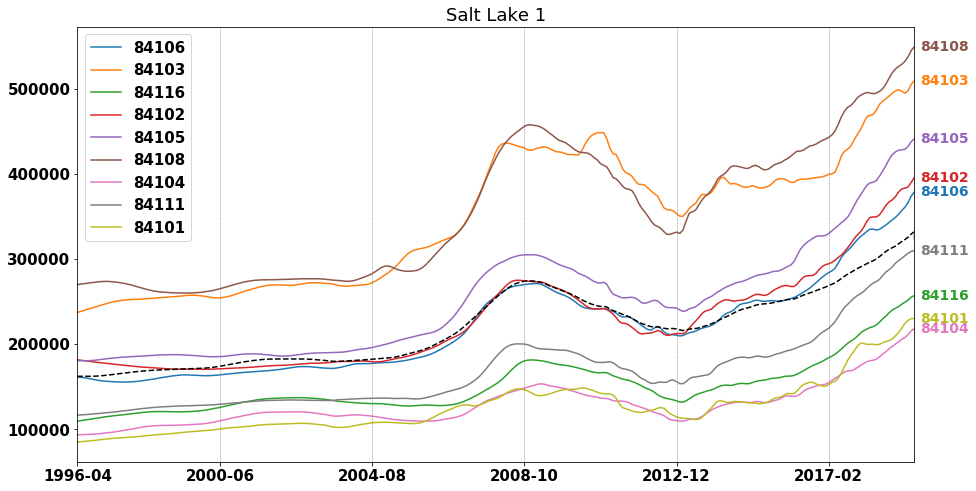

In [50]:
visualise_counties(to_plot[0],to_plot_names[0])

### Salt Lake 1
following zipcodes seem to be outperforming the rest:
* 84104
* 84102
* 84103
* 84106
* 84105



In [55]:
zipcodes_to_explore.append(84104)
zipcodes_to_explore.append(84102)
zipcodes_to_explore.append(84103)
zipcodes_to_explore.append(84106)
zipcodes_to_explore.append(84105)

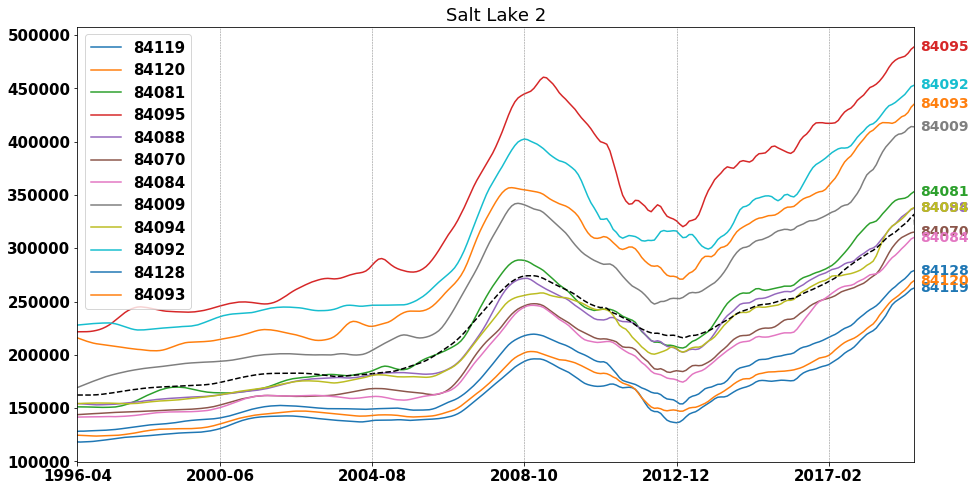

In [56]:
visualise_counties(to_plot[1],to_plot_names[1])

### Salt Lake 2
following zipcodes seem to be outperforming the rest:
* 84095
* 84093
* 84092
* 84009


In [57]:
zipcodes_to_explore.append(84095)
zipcodes_to_explore.append(84093)
zipcodes_to_explore.append(84092)
zipcodes_to_explore.append(84009)

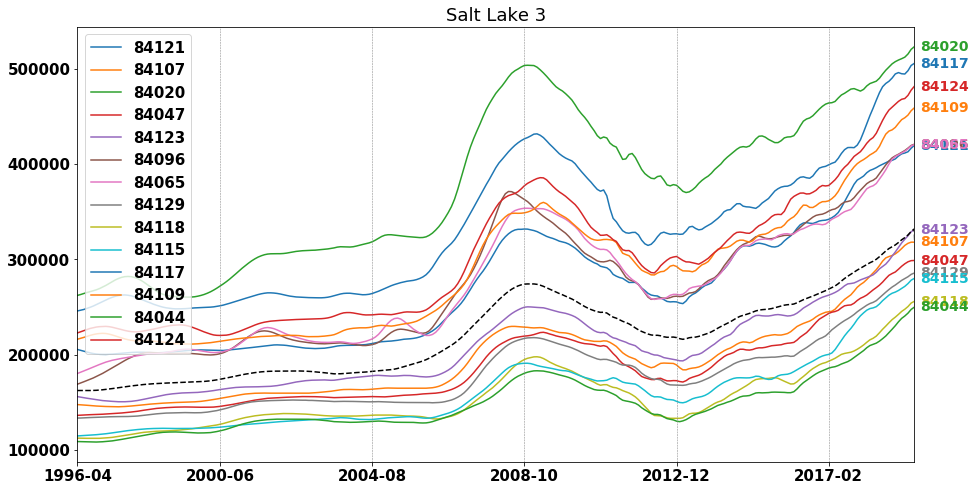

In [58]:
visualise_counties(to_plot[2],to_plot_names[2])

### Salt Lake 3 
following zipcodes seem to be outperforming the rest:
* 84117
* 84020
* 84124
* 84109
* 84065
* 84121

In [59]:
zipcodes_to_explore.append(84117)
zipcodes_to_explore.append(84020)
zipcodes_to_explore.append(84124)
zipcodes_to_explore.append(84109)
zipcodes_to_explore.append(84065)
zipcodes_to_explore.append(84121)

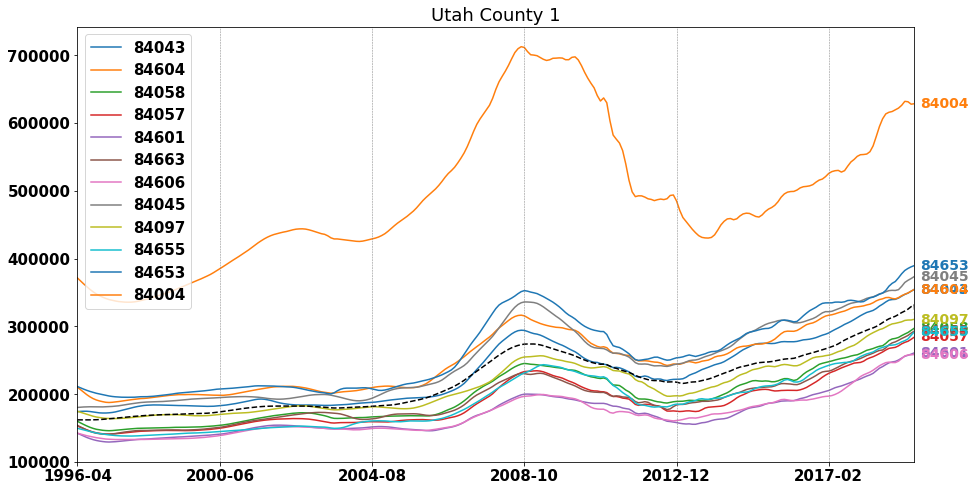

In [60]:
visualise_counties(to_plot[3],to_plot_names[3])

### Utah County 1 
following zipcodes seem to be outperforming the rest:


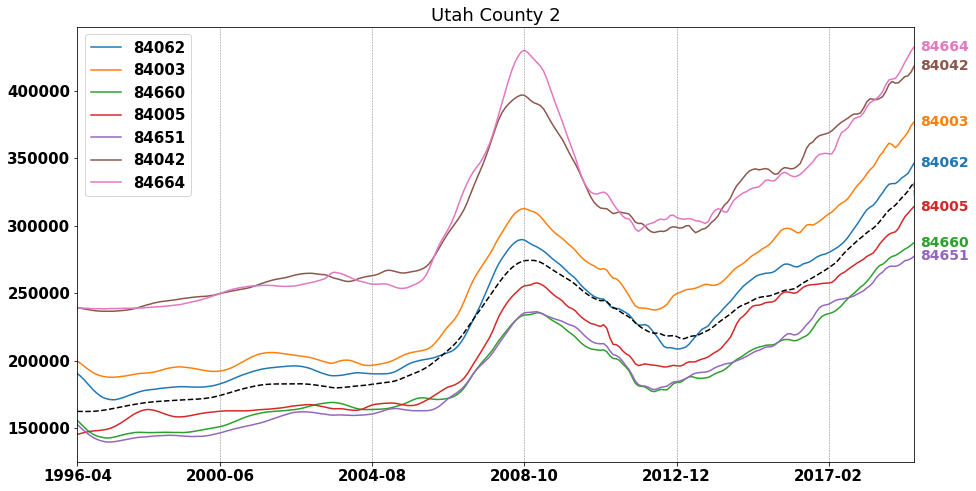

In [61]:
visualise_counties(to_plot[4],to_plot_names[4])

### Utah County 2
following zipcodes seem to be outperforming the rest:


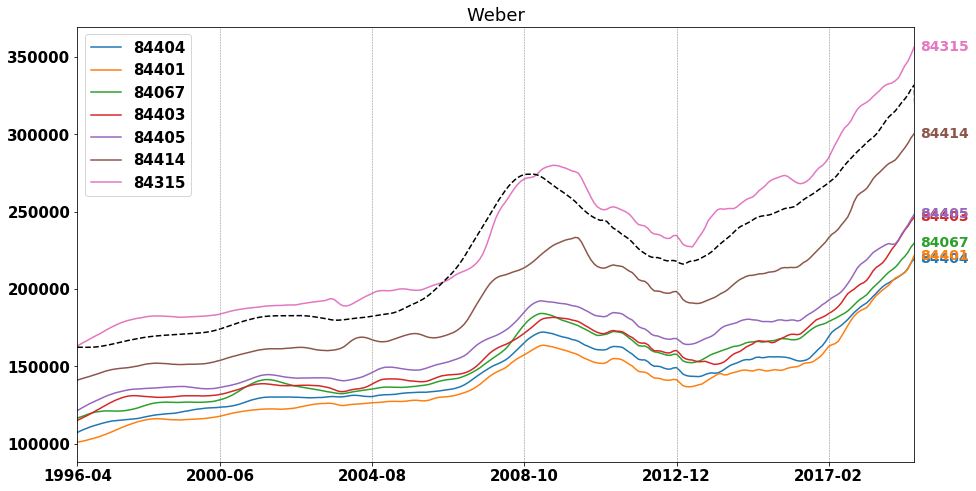

In [62]:
visualise_counties(to_plot[5],to_plot_names[5])

### Weber
following zipcodes seem to be outperforming the rest:
* 84315

In [63]:
zipcodes_to_explore.append(84315)

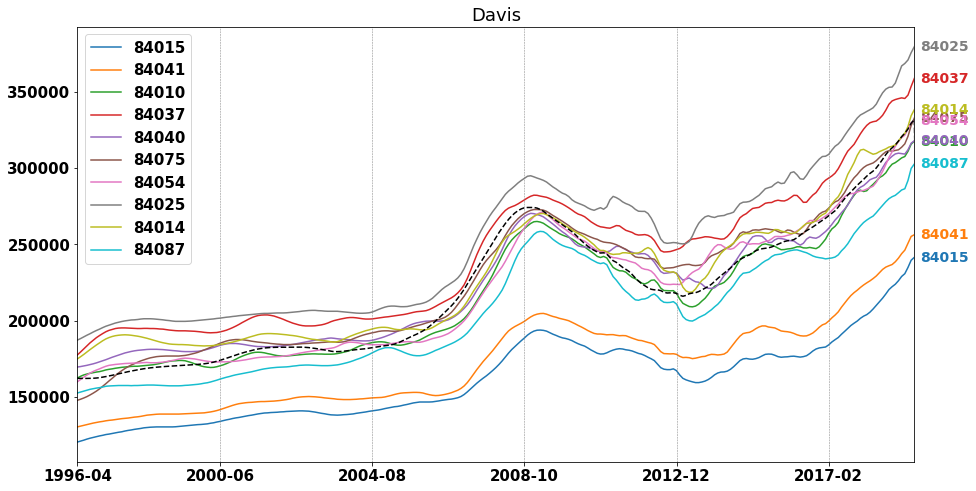

In [64]:
visualise_counties(to_plot[6],to_plot_names[6])

### Davis
following zipcodes seem to be outperforming the rest:
* 84037
* 84025

In [65]:
zipcodes_to_explore.append(84037)
zipcodes_to_explore.append(84025)

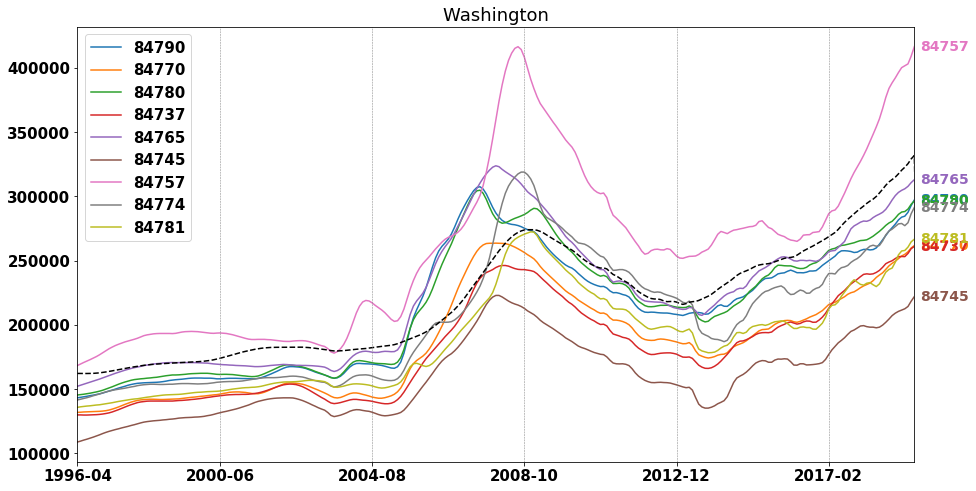

In [66]:
visualise_counties(to_plot[7],to_plot_names[7])

### Washington
following zipcodes seem to be outperforming the rest:
* 84757


In [67]:
zipcodes_to_explore.append(84757)

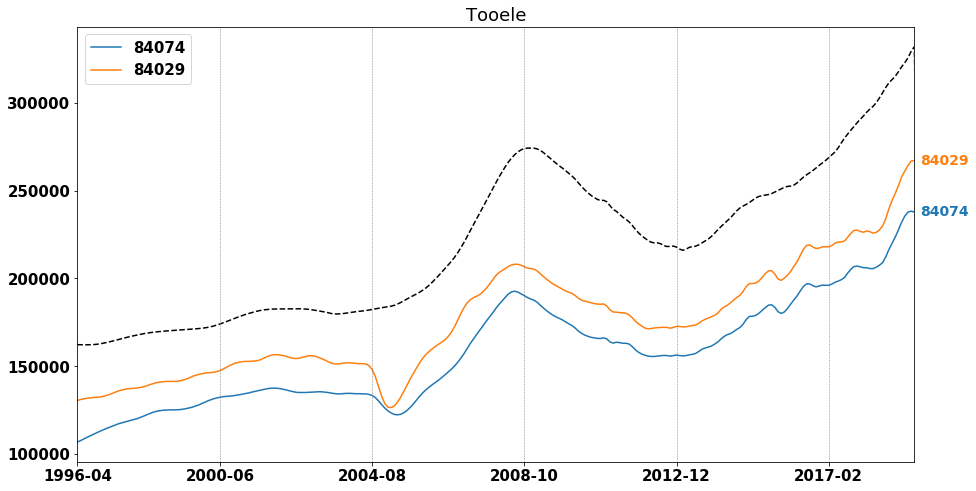

In [68]:
visualise_counties(to_plot[8],to_plot_names[8])

### Tooele
following zipcodes seem to be outperforming the rest:


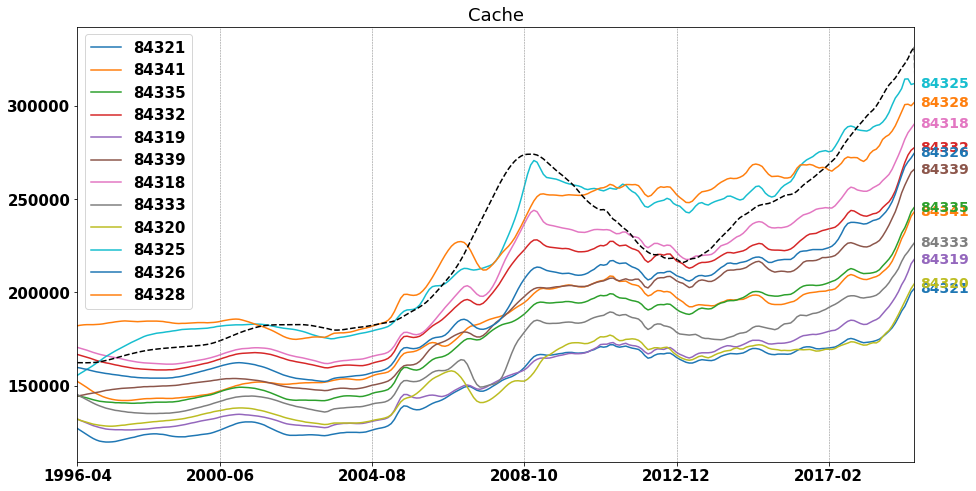

In [69]:
visualise_counties(to_plot[9],to_plot_names[9])

### Cache
following zipcodes seem to be outperforming the rest:
* 84325
* 84328

In [70]:
zipcodes_to_explore.append(84325)
zipcodes_to_explore.append(84328)

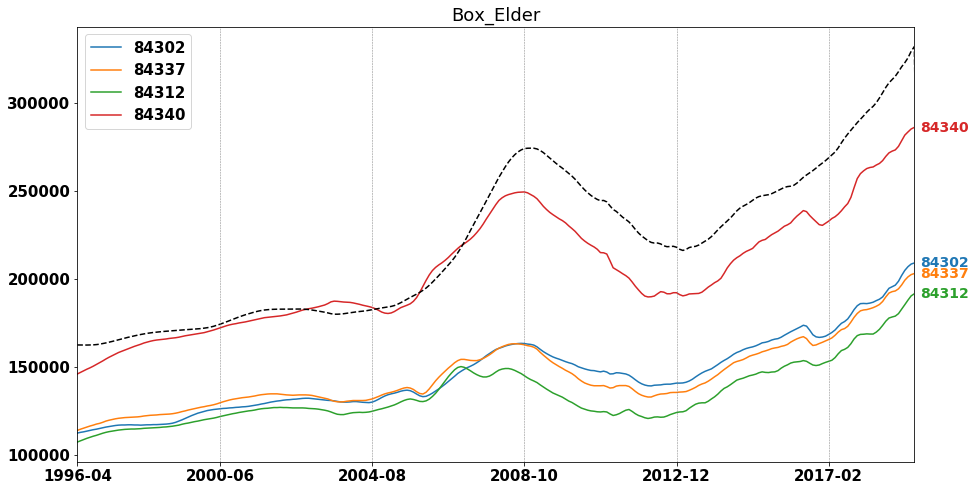

In [71]:
visualise_counties(to_plot[10],to_plot_names[10])

### Box Elder
following zipcodes seem to be outperforming the rest:


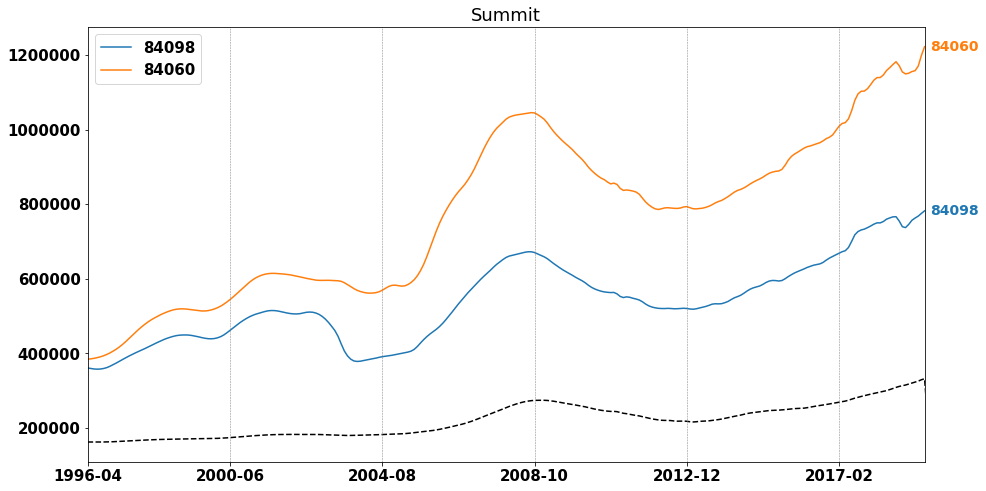

In [72]:
visualise_counties(to_plot[11],to_plot_names[11])

### Summit
following zipcodes seem to be outperforming the rest:
* 84098
* 84060

In [73]:
zipcodes_to_explore.append(84098)
zipcodes_to_explore.append(84060)

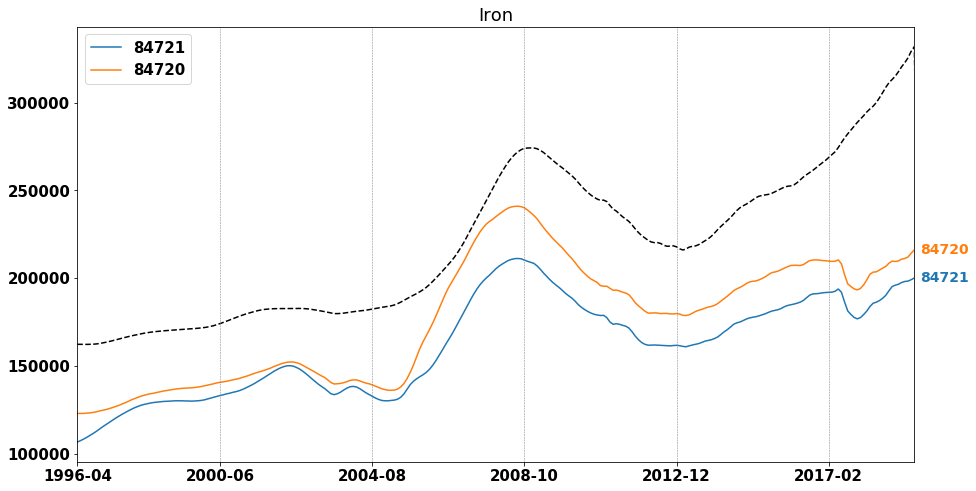

In [74]:
visualise_counties(to_plot[12],to_plot_names[12])

## Comparing selected zipcodes

In [76]:
#testing next viz
len(zipcodes_to_explore)

23

In [104]:
#creating new DF with selected series
viz_0 = pd.DataFrame(utah_df[int(zipcodes_to_explore[0])])
viz_1 = pd.DataFrame(utah_df[int(zipcodes_to_explore[1])])
viz_2 = pd.DataFrame(utah_df[int(zipcodes_to_explore[2])])
viz_3 = pd.DataFrame(utah_df[int(zipcodes_to_explore[3])])
viz_4 = pd.DataFrame(utah_df[int(zipcodes_to_explore[4])])
viz_5 = pd.DataFrame(utah_df[int(zipcodes_to_explore[5])])
viz_6 = pd.DataFrame(utah_df[int(zipcodes_to_explore[6])])
viz_7 = pd.DataFrame(utah_df[int(zipcodes_to_explore[7])])
viz_8 = pd.DataFrame(utah_df[int(zipcodes_to_explore[8])])
viz_9 = pd.DataFrame(utah_df[int(zipcodes_to_explore[9])])
viz_10 = pd.DataFrame(utah_df[int(zipcodes_to_explore[10])])
viz_11 = pd.DataFrame(utah_df[int(zipcodes_to_explore[11])])


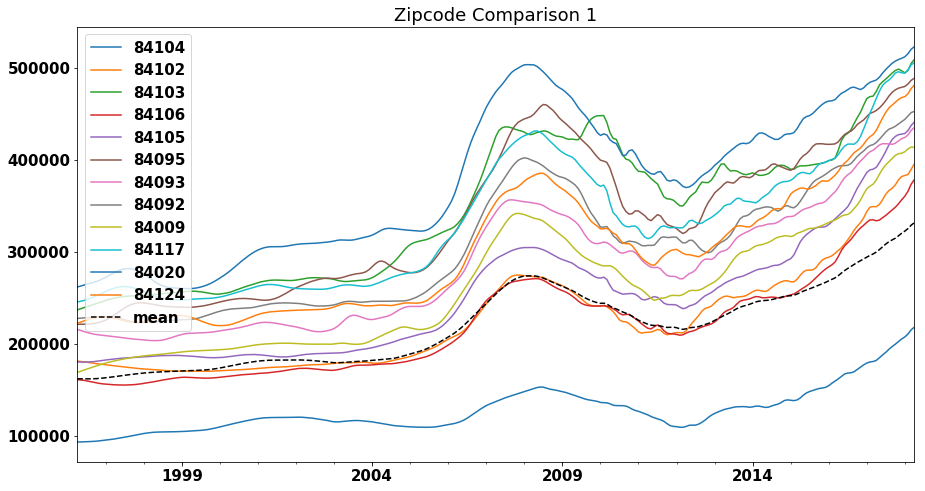

In [105]:
#calculate benchmark - average 
utah_df['mean'] = utah_df.mean(axis=1)
mean_for_final_viz = utah_df['mean']


mean_for_final_viz = pd.DataFrame(mean_for_final_viz)

to_concat = [viz_0,viz_1,viz_2,viz_3,viz_4,viz_5,viz_6,viz_7,viz_8,viz_9,viz_10,viz_11,mean_for_final_viz]

final_viz_1 = pd.concat(to_concat, axis=1)

#plt.plot(mean, color='grey', linestyle='dashed')
final_viz_1.plot(figsize=(15,8))
plt.title('Zipcode Comparison 1');
plt.gca().get_lines()[12].set_color('black')
plt.gca().get_lines()[12].set_linestyle('dashed')
plt.legend();

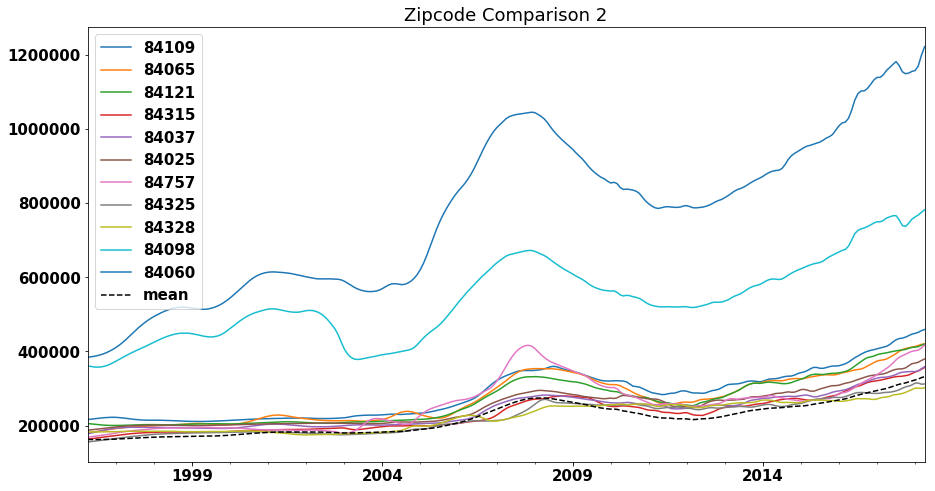

In [118]:
#creating new DF with selected series
viz_12 = pd.DataFrame(utah_df[int(zipcodes_to_explore[12])])
viz_13 = pd.DataFrame(utah_df[int(zipcodes_to_explore[13])])
viz_14 = pd.DataFrame(utah_df[int(zipcodes_to_explore[14])])
viz_15 = pd.DataFrame(utah_df[int(zipcodes_to_explore[15])])
viz_16 = pd.DataFrame(utah_df[int(zipcodes_to_explore[16])])
viz_17 = pd.DataFrame(utah_df[int(zipcodes_to_explore[17])])
viz_18 = pd.DataFrame(utah_df[int(zipcodes_to_explore[18])])
viz_19 = pd.DataFrame(utah_df[int(zipcodes_to_explore[19])])
viz_20 = pd.DataFrame(utah_df[int(zipcodes_to_explore[20])])
viz_21 = pd.DataFrame(utah_df[int(zipcodes_to_explore[21])])
viz_22 = pd.DataFrame(utah_df[int(zipcodes_to_explore[22])])


to_concat_2 = [viz_12,viz_13,viz_14,viz_15,viz_16,viz_17,viz_18,viz_19,viz_20,viz_21,viz_22,mean_for_final_viz]

final_viz_2 = pd.concat(to_concat_2, axis=1)

#plt.plot(mean, color='grey', linestyle='dashed')
final_viz_2.plot(figsize=(15,8))
plt.title('Zipcode Comparison 2');
plt.gca().get_lines()[11].set_color('black')
plt.gca().get_lines()[11].set_linestyle('dashed')
plt.legend();

## Comparing percentage change

In [122]:
to_concat_3 = [final_viz_1, final_viz_2]

df_pct = pd.concat(to_concat_3, axis=1)
df_pct.drop('mean', axis=1, inplace=True)

In [134]:
pct_change = df_pct.pct_change().mean()
pct_change.sort_values(ascending=False)

84060    0.004433
84757    0.003511
84009    0.003419
84105    0.003415
84106    0.003262
84065    0.003252
84104    0.003248
84095    0.003037
84315    0.002987
84102    0.002985
84098    0.002984
84124    0.002955
84103    0.002930
84109    0.002881
84117    0.002766
84121    0.002733
84025    0.002694
84093    0.002686
84037    0.002681
84325    0.002660
84020    0.002650
84092    0.002634
84328    0.001933
dtype: float64

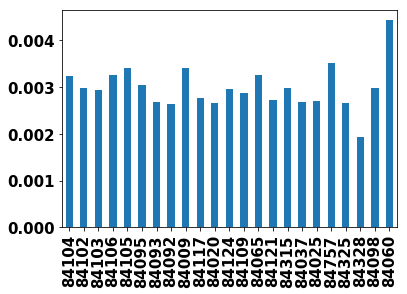

In [153]:
pct_change.plot.bar()

In [148]:
utah_df.pct_change().mean().sort_values(ascending=False).head(14)

84060    0.004433
84101    0.003837
84111    0.003738
84757    0.003511
84096    0.003501
84009    0.003419
84105    0.003415
84115    0.003415
84116    0.003263
84106    0.003262
84065    0.003252
84104    0.003248
84081    0.003248
84044    0.003184
dtype: float64

In [58]:
#attempting subplots

#to_plot = [weber, davis]
#to_plot_names = ['weber', 'davis']

#fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,4),sharex=True)
#fig.subplots_adjust(top=0.92, bottom=0.08, left=0.01, right=0.9, hspace=0.25,wspace=0.2)
#fig.suptitle('Average house price in Utah counties')

#for ax, feature, name in zip(axes.flatten(), to_plot, to_plot_names):

 #   ax.plot(feature)
  #  ax.xaxis.set_major_formatter(plt.NullFormatter())
   # plt.legend(feature)

    


### Preparing for SARIMA modelling

In [288]:
#defining a function to carry out Dickey-Fuller Test
def DF_test(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)
    
    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)

    
#defining a function for differencing   
def difference(ts):
    ts = ts.diff(periods=1)
    ts = ts.dropna()
    return ts


#defining a function to plot PACF (partial autocorrelation function)
def pacf(ts,lag):
    rcParams['figure.figsize'] = 14, 5
    plot_pacf(ts, lags = lag);
    
#defining function to substract the rolling mean  
def minus_rollmean(ts,window):
    rolmean = ts.rolling(window = window).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    return data_minus_rolmean

#diagnostics for SARIMA output
def diagnostics(output):
    output.plot_diagnostics(figsize=(11, 11))
    plt.show()

    
    
def get_predictions(ts,output,time_from):
    pred = output.get_prediction(start=pd.to_datetime(time_from), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = ts.plot(label='Observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show() 
    
    
    
def get_predictions(ts,output,time_from):
    pred = output.get_prediction(start=pd.to_datetime(time_from), dynamic=False)
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = ts.plot(label='Observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.2)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()

    plt.show()
    
    values_forecasted = pred.predicted_mean
    values_truth = ts
    
    rmse = np.sqrt(mean_squared_error(values_truth[time_from:], values_forecasted))
    print('RMSE: '+str(rmse))
    print('mean: '+str(ts[time_from:].mean()))


#code to plot rollmean 
#rolmean = s_zip84404_diff.rolling(window = 4).mean()
#fig = plt.figure(figsize=(11,7))
#orig = plt.plot(s_zip84404_diff, color='blue',label='Original')
#mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#plt.legend(loc='best')
#plt.title('Rolling Mean & Standard Deviation')
#plt.show(block=False)

In [165]:
diff_84060 = difference(utah_df[int(84060)])

In [166]:
DF_test(diff_84060)

(-2.577763152515203, 0.09768081473264839, 16, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 4534.681701393765)
Results of Dickey-Fuller Test:
Test Statistic                  -2.577763
p-value                          0.097681
#Lags Used                      16.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


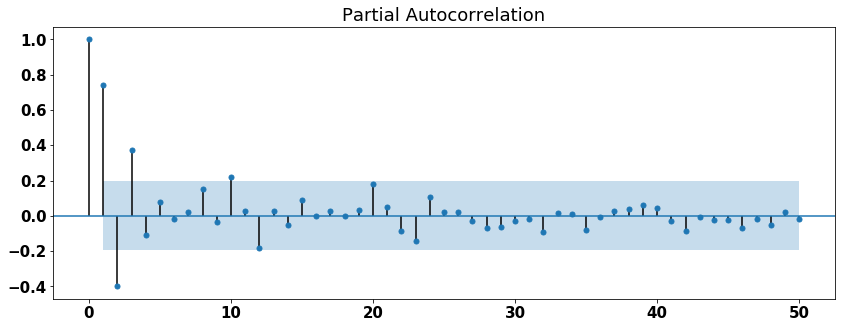

In [179]:
pacf(diff_84060['2010':],50)

In [185]:
difff_84060 = minus_rollmean(diff_84060,10)

In [186]:
DF_test(difff_84060)
#now this series is stationary

(-3.3712223708681277, 0.011979903693148069, 14, 240, {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}, 4332.2548395921995)
Results of Dickey-Fuller Test:
Test Statistic                  -3.371222
p-value                          0.011980
#Lags Used                      14.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


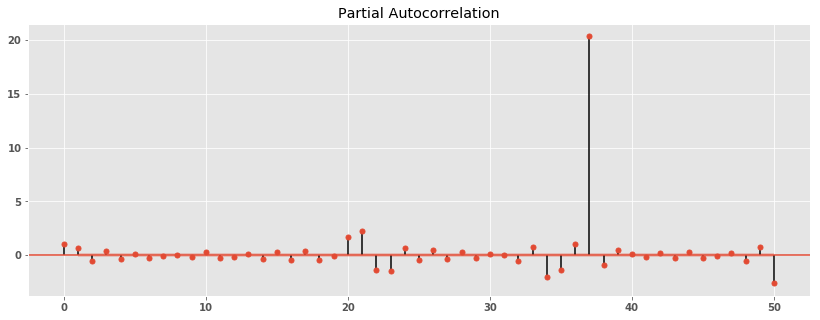

In [289]:
pacf(difff_84060['2010':],50)
#the seasonality seems to be 3!

# Step 5: ARIMA Modeling

In [189]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs =  [(x[0], x[1], x[2], 3) for x in pdq]

pdqs

[(0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3)]

In [293]:
def s_params(season):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0,2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    #return pdq

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
    pdqs =  [(x[0], x[1], x[2], season) for x in pdq]
    return pdq,pdqs

In [294]:
pdq =s_params(37)[0]
pdqs =s_params(37)[1]

In [295]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(utah_df[int(84060)],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}season : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [296]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 37)
aic           3587.01
Name: 63, dtype: object

In [297]:
# plug the optimal parameter values into a new SARIMAX model
# 'output' variable is now our model!
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(utah_df[int(84060)],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 37),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8929      0.037     24.421      0.000       0.821       0.965
ma.L1          0.8138      0.028     28.858      0.000       0.759       0.869
ar.S.L37       0.1559      0.082      1.901      0.057      -0.005       0.317
ma.S.L37      -0.2406      0.096     -2.502      0.012      -0.429      -0.052
sigma2      1.054e+07   6.59e+05     15.998      0.000    9.25e+06    1.18e+07


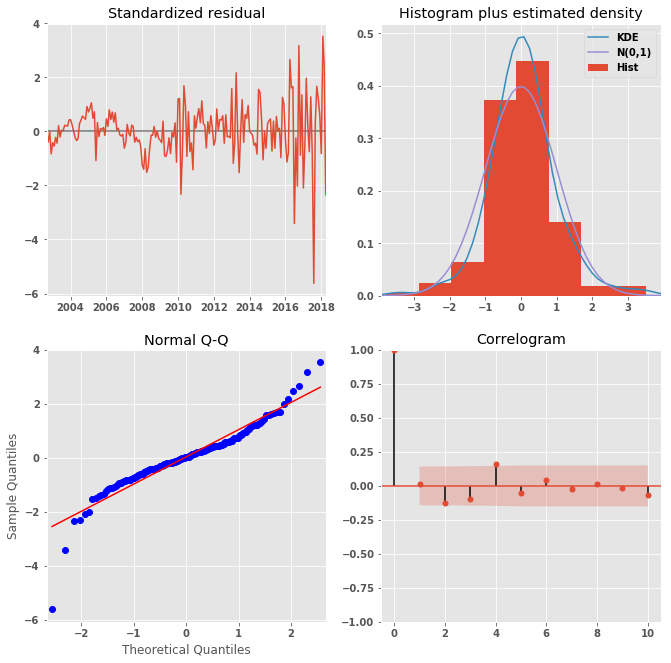

In [298]:
# Use plot_diagnostics with results calculated above   
diagnostics(output)

In [299]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.
pred = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False)
pred_conf = pred.conf_int()

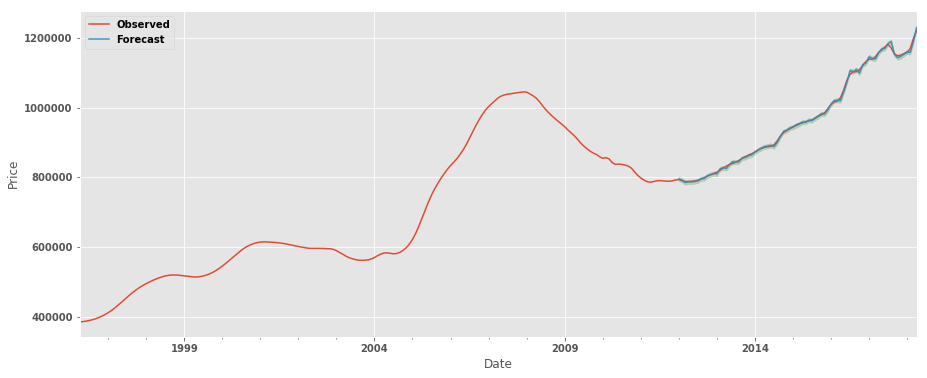

RMSE: 4483.419812219312
mean: 967840.7894736842


In [300]:
get_predictions(utah_df[int(84060)],output,'2012-01-01')

In [301]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [280]:
# Plot the dynamic forecast with confidence intervals.

#ax = utah_df[int(84060)]['2012':].plot(label='observed', figsize=(20, 15))
#pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

#ax.fill_between(pred_dynamic_conf.index,
               # pred_dynamic_conf.iloc[:, 0],
                #pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

#ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

#ax.set_xlabel('Date')
#ax.set_ylabel('Price')

#plt.legend()
#plt.show()

In [285]:
# Extract the predicted and true values of our time series
#CO2_forecasted = pred_dynamic.predicted_mean
#CO2_truth = utah_df[int(84404)]['2013-01-01':]

# Compute the mean square error
#mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

In [307]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=75)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

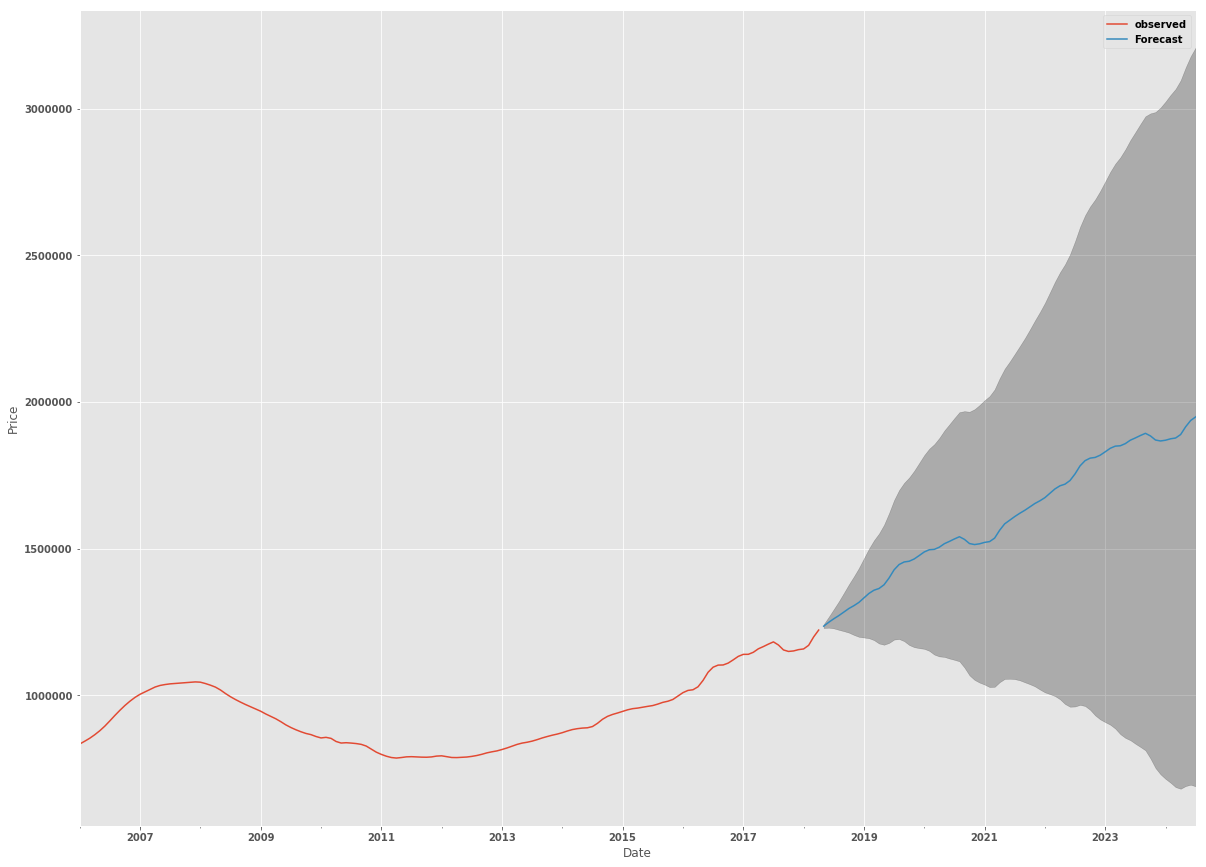

In [308]:
ax = utah_df[int(84060)]['2006':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Step 6: Interpreting Results